## Predictive Analysis on Colts Subreddit--- Part 2

### Intro
Part 1 involved pulling data from the Colts subreddit and merging it with the defensive stats data per week. Part 2 takes this data and uses Multiple Linear Regression to predict the subreddit counts of each player based on that players stats for a game. 

**Notes**
1. If a player did not play in a game, but was mentioned 1+ times in the Colts subreddit, I changed that players reddit count to zero for that particular game.
2. Justin Houston's data was removed from the model - last name overinflated counts
3. Model was build using data from **Week 1-13** and **Week 14** was used for predictions



Let's get to it!

In [552]:
#Import Libraries that will be needed
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math


In [411]:
os.chdir(r'C:\Users\ddudley\Documents\UpdatedRed')
filelist2 = glob.glob('*.csv')
print(filelist2)

['week10_upd.csv', 'week11_upd.csv', 'week12_upd.csv', 'week13_upd.csv', 'week1_upd.csv', 'week2_upd.csv', 'week3_upd.csv', 'week4_upd.csv', 'week5_upd.csv', 'week7_upd.csv', 'week8_upd.csv', 'week9_upd.csv']


### Merge Weeks 1-13 results into one dataframe

In [412]:
merged_df2 = pd.DataFrame()
for file in filelist2:
    df2 = pd.read_csv(file)
    merged_df2 = merged_df2.append(df2,ignore_index=True)

**Clean Dataframe**

In [413]:
merged_df2.drop('Unnamed: 0', axis = 1,inplace = True)

In [414]:
merged_df2.set_index(['Player'],inplace = True)

In [538]:
print("This dataset contains {} columns, and {} rows".format(merged_df2.shape[1],merged_df2.shape[0]))

This dataset contains 15 columns, and 336 rows


In [539]:
#check if the there are any null values, and if there are then assign them a value of 0
merged_df2.isnull().sum()

Week              0
T_Snaps           0
T_pressure        0
Sacks             0
Hurries           0
T_Tackles         0
Missed_Tackles    0
Stop              0
Forced_Fumble     0
Int               0
Pass_Breakup      0
Penalty           0
y_per_rec         0
rec               0
red_count         0
dtype: int64

In [540]:
merged_df2 = merged_df2.fillna(0)

In [542]:
# create new df which drop rows where player did not play a snap
merged_df_played = merged_df2[merged_df2.T_Snaps != 0]

In [630]:
#drop justin houston from the project because his last name causes problems
merged_df_played = merged_df_played[merged_df_played.index != 'Justin Houston']

In [632]:
#final dataframe used for modeling- first 15 rows:
merged_df_played.head(15)

,Week,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,,
Anthony Walker,10,48,0,0,0,0,1,0,0.0,0,0,0,20.0,1,4
Bobby Okereke,10,19,0,0,0,3,0,1,0.0,0,0,0,0.0,0,0
Darius Leonard,10,65,2,1,1,9,0,5,1.0,1,0,0,12.8,4,54
Denico Autry,10,48,4,0,3,0,0,0,0.0,0,0,0,0.0,0,1
Ben Banogu,10,16,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0
Al-Quadin Muhammad,10,22,3,0,2,1,2,1,0.0,0,0,0,0.0,0,0
Jabaal Sheard,10,46,3,1,2,1,0,2,0.0,0,0,0,9.0,1,8
Trevon Coley,10,2,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0
Margus Hunt,10,37,2,0,1,1,1,1,0.0,0,0,0,0.0,0,1


---

### Create one dataframe summing all data for each player - useful for plotting

In [421]:
f1 = r'C:\Users\ddudley\Documents\UpdatedRed\week1_upd.csv'
f2 = r'C:\Users\ddudley\Documents\UpdatedRed\week2_upd.csv'
f3 = r'C:\Users\ddudley\Documents\UpdatedRed\week3_upd.csv'
f4 = r'C:\Users\ddudley\Documents\UpdatedRed\week4_upd.csv'
f5 = r'C:\Users\ddudley\Documents\UpdatedRed\week5_upd.csv'
#f6 = r'C:\Users\ddudley\Documents\UpdatedRed\week6_upd.csv'
f7 = r'C:\Users\ddudley\Documents\UpdatedRed\week7_upd.csv'
f8 = r'C:\Users\ddudley\Documents\UpdatedRed\week8_upd.csv'
f9 = r'C:\Users\ddudley\Documents\UpdatedRed\week9_upd.csv'
f10 = r'C:\Users\ddudley\Documents\UpdatedRed\week10_upd.csv'
f11 = r'C:\Users\ddudley\Documents\UpdatedRed\week11_upd.csv'
f12 = r'C:\Users\ddudley\Documents\UpdatedRed\week12_upd.csv'
f13 = r'C:\Users\ddudley\Documents\UpdatedRed\week13_upd.csv'



In [422]:
df1 = pd.read_csv(f1)
df1 = df1.reset_index(drop=True)
df1 = df1.drop('Unnamed: 0', axis=1)
df2 = pd.read_csv(f2)
df2 = df2.drop('Unnamed: 0', axis=1)
df3 = pd.read_csv(f3)
df3 = df3.drop('Unnamed: 0', axis=1)
df4 = pd.read_csv(f4)
df4 = df4.drop('Unnamed: 0', axis=1)
df5 = pd.read_csv(f5)
df5 = df5.drop('Unnamed: 0', axis=1)
#df6 = pd.read_csv(f6)
df7 = pd.read_csv(f7)
df7 = df7.drop('Unnamed: 0', axis=1)
df8 = pd.read_csv(f8)
df8 = df8.drop('Unnamed: 0', axis=1)
df9 = pd.read_csv(f9)
df9 = df9.drop('Unnamed: 0', axis=1)
df10 = pd.read_csv(f10)
df10 = df10.drop('Unnamed: 0', axis=1)
df11 = pd.read_csv(f11)
df11 = df11.drop('Unnamed: 0', axis=1)
df12 = pd.read_csv(f12)
df12 = df12.drop('Unnamed: 0', axis=1)
df13 = pd.read_csv(f13)
df13 = df13.drop('Unnamed: 0', axis=1)



In [423]:
#Create dataframe that summs game stats from Week 1-12
dfs = [df1, df2, df3,df4,df5,df7,df8,df9,df10,df11,df12,df13]
summed_df = pd.concat(dfs).groupby('Player', as_index=False).sum()

In [424]:
summed_df.drop(['Week'], axis =1, inplace = True)

In [425]:
#drop justin houston
summed_df = summed_df[summed_df.Player != 'Justin Houston']

In [547]:
summed_df.sort_values(by = ['red_count'],ascending = False)

,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,
Rock Ya-Sin,571,0,0,0,38,3,14,0.0,1,1,7,151.9,28,474
Darius Leonard,552,13,5,7,53,5,23,2.0,2,0,2,85.0,40,459
Kenny Moore,651,7,3,3,53,7,31,0.0,2,1,0,110.0,39,371
Malik Hooker,504,0,0,0,23,7,7,0.0,1,1,0,30.0,4,216
Quincy Wilson,105,0,0,0,8,0,2,0.0,0,0,3,74.2,10,167
Khari Willis,459,4,0,4,39,6,15,0.0,0,1,1,56.5,15,122
Bobby Okereke,346,1,1,0,28,4,16,1.0,1,1,0,63.0,21,121
Kemoko Turay,81,14,2,8,2,0,3,1.0,0,0,1,0.0,0,108
Anthony Walker,579,6,2,4,57,16,38,1.0,0,1,0,109.8,37,102


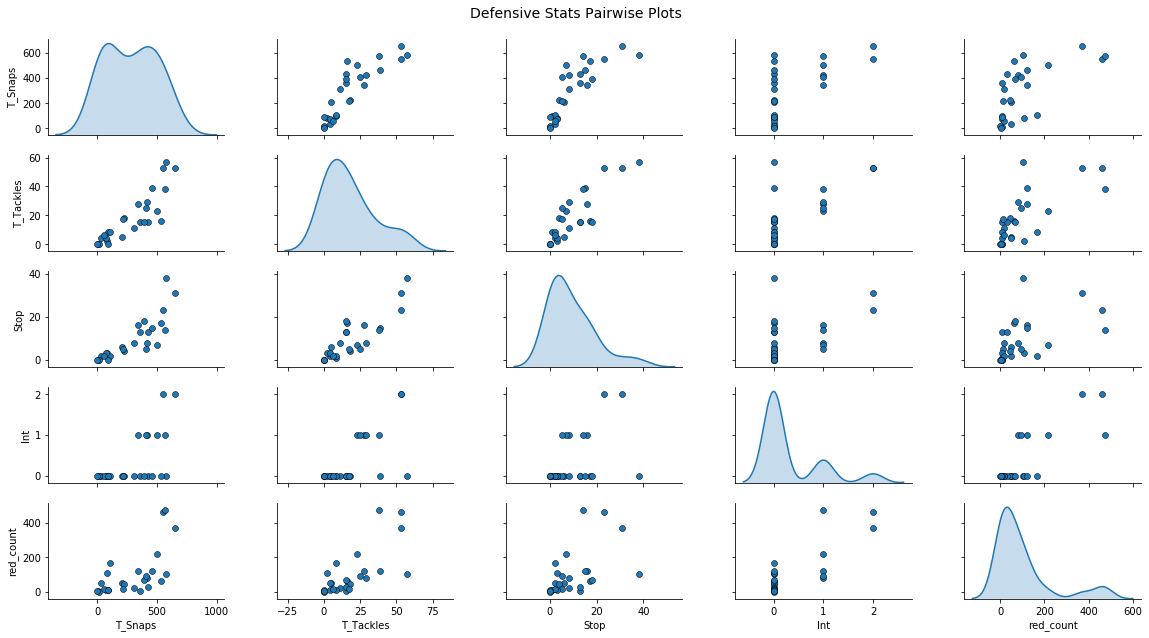

In [556]:
import seaborn as sns

# Pair-wise Scatter Plots
# Let's pick out a few features to look at 
cols = ['T_Snaps', 'T_Tackles', 'Stop', 'Int','red_count']

pp = sns.pairplot(summed_df[cols], size=1.8, aspect=1.8,

                  plot_kws=dict(edgecolor="k", linewidth=0.5),

                  diag_kind="kde", diag_kws=dict(shade=True))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Defensive Stats Pairwise Plots', fontsize=14)

The four features plotted against red_count generally show a positive correlation

---

## Multiple Linear Regression Modeling

In [548]:
#from sklearn.metrics import SCORERS
#print(SCORERS.keys())

**Analyze the correlation between each feature and the reddit counts to help decide what features to use in modeling**

In [433]:
from scipy import stats

pearson_coef, p_value = stats.pearsonr(merged_df_played['T_Snaps'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient total snaps is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['T_Tackles'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for T_Tackles is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Stop'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for stops is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Int'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for interceptions is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['rec'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for receptions is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Sacks'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Sacks is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['y_per_rec'],merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for yards per reception is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Penalty'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for penalties is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['T_pressure'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Total Pressures is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Hurries'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Hurries is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Forced_Fumble'],merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Forced Fumbles is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Missed_Tackles'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Missed Tackles is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(merged_df_played['Pass_Breakup'], merged_df_played['red_count'])
print("The Pearson Correlation Coefficient for Pass Breakups is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient total snaps is 0.33277676538546036  with a P-value of P = 4.360643845736733e-07
The Pearson Correlation Coefficient for T_Tackles is 0.34468846204769543  with a P-value of P = 1.5623503501412543e-07
The Pearson Correlation Coefficient for stops is 0.21994976178359674  with a P-value of P = 0.0010230583288739071
The Pearson Correlation Coefficient for interceptions is 0.31894179142232193  with a P-value of P = 1.3621019108476299e-06
The Pearson Correlation Coefficient for receptions is 0.37425657435076065  with a P-value of P = 1.0098454289281703e-08
The Pearson Correlation Coefficient for Sacks is 0.07761751344707721  with a P-value of P = 0.2516190371091403
The Pearson Correlation Coefficient for yards per reception is 0.31630437202657874  with a P-value of P = 1.6817126953146985e-06
The Pearson Correlation Coefficient for penalties is 0.5412776187407526  with a P-value of P = 3.820411832008524e-18
The Pearson Correlation Coefficient for Total Press

---------------------------------------------
# Using Cross Validation To Help Select Features

### Model A: Model using all features

In [434]:
#create feature and predictor variables 
XDATA=merged_df_played.drop(['red_count','Week'], axis =1)
print(XDATA.shape)
YDATA =merged_df_played[['red_count']]
print(YDATA.shape)

(220, 13)
(220, 1)


In [435]:
XDATA.head(2)

,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec
Player,,,,,,,,,,,,,
Anthony Walker,48,0,0,0,0,1,0,0.0,0,0,0,20.0,1
Bobby Okereke,19,0,0,0,3,0,1,0.0,0,0,0,0.0,0


In [456]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import cross_val_score

def regression_model_all(feature_data,predictor_data):
    
    global regression_model_all
    regression_model_all = LinearRegression(normalize = True)
    global scores_all
    scores_all = cross_val_score(regression_model_all,feature_data,predictor_data,cv=10, scoring = 'neg_mean_squared_error')
    for_rmse = -scores_all.mean()
    print(scores_all)
    print("The average mse for this model is: {}".format(scores_all.mean()))
    print("Make positive: {}".format(scores_all.mean()*-1))
    print("RMSE: {}".format(math.sqrt(for_rmse)))
     

In [437]:
#model with non-normalized data!
regression_model_all(XDATA,YDATA)

[  -93.85625121  -786.74371338  -554.05508557  -267.41640559
  -161.06961113  -174.32418113  -323.26305123  -592.48139541
 -1404.51866681  -605.65316481]
The average mse for this model is: -496.3381526250334
Make positive: 496.3381526250334
RMSE: 22.27864790836808


Should the data be normalized? Lets test setting normalizing = True


In [457]:
regression_model_all(XDATA,YDATA)

[  -93.85625121  -786.74371338  -554.05508557  -267.41640559
  -161.06961113  -174.32418113  -323.26305123  -592.48139541
 -1404.51866681  -605.65316481]
The average mse for this model is: -496.33815262503305
Make positive: 496.33815262503305
RMSE: 22.27864790836807


**Normalizing the data resulted in little to no difference** of the mse metric

### Model B: Model using Top 7 most correlated features

In [440]:
def regression_model_top7(feature_data,predictor_data):
    
    global regression_model_top7
    regression_model_top7 = LinearRegression(normalize = False)
    global scores_top7
    scores_top7 = cross_val_score(regression_model_top7,feature_data,predictor_data,cv=10, scoring = 'neg_mean_squared_error')
    for_rmse = -scores_top7.mean()
    print(scores_top7)
    print("The average mse for this model is: {}".format(scores_top7.mean()))
    print("Make positive: {}".format(scores_top7.mean()*-1))
    print("RMSE: {}".format(math.sqrt(for_rmse)))
    

In [441]:
XDATA_top7=merged_df_played.drop(['red_count','Pass_Breakup','Week','Missed_Tackles','Forced_Fumble','Hurries','T_pressure','Sacks',], axis =1)
YDATA_top7 =merged_df_played[['red_count']]

In [442]:
XDATA_top7.head(2)

,T_Snaps,T_Tackles,Stop,Int,Penalty,y_per_rec,rec
Player,,,,,,,
Anthony Walker,48,0,0,0,0,20.0,1
Bobby Okereke,19,3,1,0,0,0.0,0


In [443]:
regression_model_top7(XDATA_top7,YDATA_top7)

[  -72.68964881  -678.84926448  -584.64370193  -236.0090249
  -125.82234989  -134.31967159  -311.09676569  -673.65127785
 -1441.1896155   -650.39121847]
The average mse for this model is: -490.86625391106566
Make positive: 490.86625391106566
RMSE: 22.155501662365168


### Model C: Model with top 5 most correlated features

In [444]:
def regression_model_top5(feature_data,predictor_data):
    
    #global regression_model_
    regression_model_top5 = LinearRegression(normalize = False)
    global scores_top5
    scores_top5 = cross_val_score(regression_model_top5,feature_data,predictor_data,cv=10, scoring = 'neg_mean_squared_error')
    for_rmse = -scores_top5.mean()
    print(scores_top5)
    print("The average mse for this model is: {}".format(scores_top5.mean()))
    print("Make positive: {}".format(scores_top5.mean()*-1))
    print("RMSE: {}".format(math.sqrt(for_rmse)))
    

In [445]:
XDATA_top5=merged_df_played.drop(['red_count','Pass_Breakup','y_per_rec','Week','Stop','Missed_Tackles','Forced_Fumble','Hurries','T_pressure','Sacks','Stop'], axis =1)
YDATA_top5 =merged_df_played[['red_count']]



In [446]:
XDATA_top5.head(2)

,T_Snaps,T_Tackles,Int,Penalty,rec
Player,,,,,
Anthony Walker,48,0,0,0,1
Bobby Okereke,19,3,0,0,0


In [447]:
regression_model_top5(XDATA_top5,YDATA_top5)

[  -73.90431346  -670.28544723  -571.01314544  -196.65534747
  -124.9286156   -133.61003901  -314.09306857  -666.08659838
 -1431.44670947  -591.88696114]
The average mse for this model is: -477.39102457692053
Make positive: 477.39102457692053
RMSE: 21.849279726730593


### Model D: Model with top 3 most correlated features

In [587]:
def regression_model_top3(feature_data,predictor_data):
    
    #global regression_model_top3
    regression_model_top3 = LinearRegression(normalize = False)
    global scores_top3
    scores_top3 = cross_val_score(regression_model_top3,feature_data,predictor_data,cv=10, scoring = 'neg_mean_squared_error')
    for_rmse = -scores_top3.mean()
    print(scores_top3)
    print("The average mse for this model is: {}".format(scores_top3.mean()))
    print("Make positive: {}".format(scores_top3.mean()*-1))
    print("RMSE: {}".format(math.sqrt(for_rmse)))
    
   

In [449]:
XDATA_top3=merged_df_played.drop(['red_count','T_Snaps','Week','T_Tackles','Pass_Breakup','Stop','y_per_rec','T_Snaps','Missed_Tackles','Forced_Fumble','Hurries','T_pressure','Sacks','Stop'], axis =1)
YDATA_top3 =merged_df_played[['red_count']]

In [584]:
scores_top3.shape

(10,)

In [339]:
XDATA_top3.head(2)

,Int,Penalty,rec
Player,,,
Anthony Walker,0,0,1
Bobby Okereke,0,0,0


In [588]:
regression_model_top3(XDATA_top3,YDATA_top3)

[  -98.19086643  -683.47739118  -622.15024103  -203.16872237
  -112.86492159  -144.26113781  -298.81948794  -683.02524505
 -1560.04087453  -502.87440342]
The average mse for this model is: -490.8873291351082
Make positive: 490.8873291351082
RMSE: 22.15597727781621


### Which Model produced the lowest error?

In [532]:
#Comparing error results from using different sets of features
print("The RMSE for model A w/ all features is: {}".format((math.sqrt(-scores_all.mean()))))
print('--------------------------------------------------------------------------------')
print("The RMSE for model B w/ top 7 most correlated features is: {}".format(math.sqrt(-scores_top7.mean())))
print('--------------------------------------------------------------------------------')
print("The RMSE for model C w/ 5 most correlated features is: {}".format(math.sqrt(-scores_top5.mean())))
print('--------------------------------------------------------------------------------')
print("The RMSE for model D w/ 3 most correlated features  is: {}".format(math.sqrt(-scores_top3.mean())))

The RMSE for model A w/ all features is: 22.27864790836807
--------------------------------------------------------------------------------
The RMSE for model B w/ top 7 most correlated features is: 22.155501662365168
--------------------------------------------------------------------------------
The RMSE for model C w/ 5 most correlated features is: 21.849279726730593
--------------------------------------------------------------------------------
The RMSE for model D w/ 3 most correlated features  is: 22.15597727781621


As we can see from the results above, Model C produced the lowest error. We will use this model in the prediction!

---

## Predictions using Model C

In [625]:
def regression_model_predicting(feature_data,predictor_data,stat_array):
    
    #create instance of the model
    regression_model = LinearRegression(normalize = False)
    #fit model
    regression_model.fit(feature_data,predictor_data)
    global coef
    coef = regression_model.coef_
    intercept = regression_model.intercept_
    
    #Make predictions
    global predicted_count
    predicted_count = regression_model.predict(stat_array).flatten()
    print("The coefficients are: {}".format(coef))
    print("The intercept is: {}".format(intercept))
    
 
    #calculate the mean squared error
    mse = mean_squared_error(week14countlist,predicted_count)
    mae = mean_absolute_error(week14countlist,predicted_count)
    rmse = math.sqrt(mse)
    r2 = r2_score(week14countlist,predicted_count)

    #display results
    print("MSE: {}".format(mse))
    print("MAE: {}".format(mae))
    print("RMSE: {}".format(rmse))
    print("r2_score: {}".format(r2))
    return predicted_count

**For prediction, I will use the Week 14 data (not used in training model)** 

In [488]:
week14 = pd.read_csv(r'C:\Users\ddudley\Documents\week14_upd.csv')
#get list of players for creating new DF
playerlist = pd.Series(week14.Player).to_list()
week14.drop('Unnamed: 0', axis = 1,inplace = True)
week14.set_index('Player',inplace = True)

Lets view the data from Week 14!

In [629]:
week14.sort_values(by='red_count',ascending = False)

,Week,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,,
Darius Leonard,14,78,3,0,3,6,1,4,0,2,0,0,7.2,5,116
Malik Hooker,14,78,0,0,0,7,1,0,0,1,0,0,14.0,4,88
Pierre Desir,14,78,0,0,0,4,1,0,0,0,1,0,25.7,3,19
Quincy Wilson,14,4,0,0,0,0,0,0,0,0,0,0,12.0,1,14
George Odum,14,12,0,0,0,5,0,0,0,0,0,0,16.0,4,12
Rock Ya-Sin,14,75,0,0,0,3,0,0,0,0,1,0,20.5,2,9
Bobby Okereke,14,27,1,0,1,2,0,1,0,0,0,0,0.0,0,7
EJ Speed,14,0,0,0,0,0,0,0,0,0,0,0,0.0,0,6
Justin Houston,14,45,3,1,2,2,0,3,0,0,0,1,13.0,1,5


In [489]:
#create testing feature set for the prediction
x_test = week14[['T_Snaps','T_Tackles','Int','Penalty','rec']].to_numpy()
#create numpy array to be used in df, for comparing to predicted results
week14counts = week14[['red_count']].to_numpy()
week14countlist = week14counts.flatten()

In [626]:
#Run the prediction
regression_model_predicting(XDATA_top5,YDATA_top5,x_test)

The coefficients are: [[ 0.12309031  1.38555467 34.62926049 26.8231353   0.39604614]]
The intercept is: [-1.80631905]
MSE: 137.60392972753078
MAE: 7.285957551672994
RMSE: 11.730470140941955
r2_score: 0.7973950162517764


array([11.56612859, -1.80631905,  4.2882286 , 87.34680465, -1.80631905,
       -1.80631905,  5.48757039,  0.40930649, 33.72303557,  2.77958362,
        2.2556611 ,  4.22510603, -1.80631905, -1.80631905,  5.02677045,
        8.10402814, -1.80631905, -1.80631905, -1.1640923 , -0.91791168,
       12.37421031,  3.08410074, 53.70705269, 10.48509103,  8.18272254,
       22.00355313, -1.80631905, 14.52508205])

### Results!

In [602]:
df_prediction = pd.DataFrame({'Actual':week14countlist,'Predicted':predicted_count},index = playerlist)
df_prediction['Difference'] = df_prediction['Predicted'] - df_prediction['Actual']

In [604]:
df_prediction['over_under'] = np.where(df_prediction['Difference']<0,'Under','Over')

In [605]:
df_prediction

,Actual,Predicted,Difference,over_under
Anthony Walker,2,11.566129,9.566129,Over
EJ Speed,6,-1.806319,-7.806319,Under
Bobby Okereke,7,4.288229,-2.711771,Under
Darius Leonard,116,87.346805,-28.653195,Under
Zaire Franklin,0,-1.806319,-1.806319,Under
Matthew Adams,0,-1.806319,-1.806319,Under
Denico Autry,3,5.487570,2.487570,Over
Ben Banogu,0,0.409306,0.409306,Over
Justin Houston,5,33.723036,28.723036,Over
Tyquan Lewis,0,2.779584,2.779584,Over


In [606]:
print("The average difference between the prediction and actual is {} reddit counts".format(df_prediction.Difference.abs().mean()))

The average difference between the prediction and actual is 7.285957551672992 reddit counts


In [607]:
df_prediction['over_under'].value_counts()

Under    15
Over     13
Name: over_under, dtype: int64

---

### Discussion Points
1. The average difference between the actual counts and the models prediction is roughly 7 counts.
2. Of 28, the model overpredicted the count 15 times, and underpredicted 13 times. 
3. The project showed that defensive statistics can be a measure of how often a player is mentioned in the Colts subreddit game threads,  but it fails to account for context of other reasons why a players are talked about in the subreddit (i.e. player pediogre vs statistical performance, player playing through injury, etc)
4. It's fair to question the accuracy of the player statistics pulled from PFF. For example does it record every single defensive penalty? Every single pass defensed? More time could have been spent varying these statistics in Part 1. 
5. Justin Houston's data negatively impacted this project/model. Even though he leads the defense is some statistical categories, I had to delete him from the model because his last name resulted in overestimating his Reddit counts - this is because the Houston Texans are in the Colts division and the subreddit mentions that team very often. 


---

## Lagniappe; Analysis of the defensive position groups

First, I want to prepare the data by grouping dataframes by position groups

In [514]:
#Edges
JH_df = merged_df[(merged_df.index == 'Justin Houston')]
JH_df2 = JH_df.sort_values(by=['Week'])
BB_df = merged_df[(merged_df.index == 'Ben Banogu')]
BB_df2 = BB_df.sort_values(by=['Week'])
JS_df = merged_df[(merged_df.index == 'Jabaal Sheard')]
JS_df2 = JS_df.sort_values(by=['Week'])
AM_df = merged_df[(merged_df.index == 'Al-Quadin Muhammad')]
AM_df2 = AM_df.sort_values(by=['Week'])
KT_df = merged_df[(merged_df.index == 'Kemoko Turay')]
KT_df2 = KT_df.sort_values(by=['Week'])
edge_frame = [JH_df2,BB_df2,JS_df2,AM_df2,KT_df2]
edge_df = pd.concat(edge_frame)

#CB's
RYS_df = merged_df[(merged_df.index == 'Rock Ya-Sin')]
RYS_df2 = RYS_df.sort_values(by=['Week'])
KM_df = merged_df[(merged_df.index == 'Kenny Moore')]
KM_df2 = KM_df.sort_values(by=['Week'])
QW_df = merged_df[(merged_df.index == 'Quincy Wilson')]
QW_df2 = QW_df.sort_values(by=['Week'])
PD_df = merged_df[(merged_df.index == 'Pierre Desir')]
PD_df2 = PD_df.sort_values(by=['Week'])
MT_df = merged_df[(merged_df.index == 'Marvell Tell')]
MT_df2 =MT_df.sort_values(by=['Week'])
cb_frame = [RYS_df2,KM_df2,QW_df2,PD_df2,MT_df2]
cb_df = pd.concat(cb_frame)

#LB's
DL_df = merged_df[(merged_df.index == 'Darius Leonard')]
DL_df2 = DL_df.sort_values(by=['Week'])
AW_df = merged_df[(merged_df.index == 'Anthony Walker')]
AW_df2 =AW_df.sort_values(by=['Week'])
BO_df = merged_df[(merged_df.index == 'Bobby Okereke')]
BO_df2 = BO_df.sort_values(by=['Week'])
lb_frame = [DL_df2,AW_df2,BO_df2]
lb_df = pd.concat(lb_frame)

#SAF's
MH_df = merged_df[(merged_df.index == 'Malik Hooker')]
MH_df2 = MH_df.sort_values(by=['Week'])
CG_df = merged_df[(merged_df.index == 'Clayton Geathers')]
CG_df2 = CG_df.sort_values(by=['Week'])
GO_df = merged_df[(merged_df.index == 'George Odum')]
GO_df2 = GO_df.sort_values(by=['Week'])
KW_df = merged_df[(merged_df.index == 'Khari Willis')]
KW_df2 = KW_df.sort_values(by=['Week'])
saf_frame = [MH_df2,CG_df2,GO_df2,KW_df2]
saf_df = pd.concat(saf_frame)

In [649]:
summed_df.columns

Index(['T_Snaps', 'T_pressure', 'Sacks', 'Hurries', 'T_Tackles',
       'Missed_Tackles', 'Stop', 'Forced_Fumble', 'Int', 'Pass_Breakup',
       'Penalty', 'y_per_rec', 'rec', 'red_count'],
      dtype='object')

### Defensive Awards 

In [662]:
for col in summed_df:
    print("Player with max {} is: {}".format(col,summed_df[col].idxmax()))

Player with max T_Snaps is: Kenny Moore
Player with max T_pressure is: Denico Autry
Player with max Sacks is: Darius Leonard
Player with max Hurries is: Jabaal Sheard
Player with max T_Tackles is: Anthony Walker
Player with max Missed_Tackles is: Anthony Walker
Player with max Stop is: Anthony Walker
Player with max Forced_Fumble is: Darius Leonard
Player with max Int is: Darius Leonard
Player with max Pass_Breakup is: Marvell Tell
Player with max Penalty is: Rock Ya-Sin
Player with max y_per_rec is: Rock Ya-Sin
Player with max rec is: Darius Leonard
Player with max red_count is: Rock Ya-Sin


### What is the impact of getting just one more tackle? One more interception? Allowing one more reception? Having one more penalty? Play one more snap?

To answer this, we just need to observe the coefficients created by the model

In [511]:
#Let's call the coef variable that we created in the Regression_Model_Predicting function
print(coef)

[[ 0.12309031  1.38555467 34.62926049 26.8231353   0.39604614]]


In [512]:
print("If a player plays one more snap, the model predicts they will be mentioned in Reddit {} more times".format(coef[0,0]))
print("If a player gets one more tackle, the model predicts they will be mentioned in Colts Reddit {} more times".format(coef[0,1]))
print("If a player gets one more interception, the model predicts they will be mentioned in Reddit {} more times".format(coef[0,2]))
print("If a player gets one more penalty, the model predicts they will be mentioned in Reddit {} more times".format(coef[0,3]))
print("If a player allows one more reception, the model predicts they will be mentioned in Reddit {} more times".format(coef[0,4]))

If a player plays one more snap, the model predicts they will be mentioned in Reddit 0.12309030769327861 more times
If a player gets one more tackle, the model predicts they will be mentioned in Colts Reddit 1.3855546716827765 more times
If a player gets one more interception, the model predicts they will be mentioned in Reddit 34.629260493535135 more times
If a player gets one more penalty, the model predicts they will be mentioned in Reddit 26.82313529865658 more times
If a player allows one more reception, the model predicts they will be mentioned in Reddit 0.3960461358118208 more times


### Which position group has the most tackles?

In [609]:
print("The total tackles in the Edge group is: {}".format(edges['T_Tackles'].sum()))
print("The total tackles in the Linebacker group is: {}".format(lbs['T_Tackles'].sum()))
print("The total tackles in the Cornerback group is: {}".format(cbs_summed['T_Tackles'].sum()))
print("The total tackles in the Safety group is: {}".format(safs['T_Tackles'].sum()))

The total tackles in the Edge group is: 59
The total tackles in the Linebacker group is: 138
The total tackles in the Cornerback group is: 141
The total tackles in the Safety group is: 109


### Which position group has the most pressures on the opposing QB?

In [528]:
print("The total pressures in the Edge group is: {}".format(edges['T_pressure'].sum()))
print("The total pressures in the Linebacker group is: {}".format(lbs['T_pressure'].sum()))
print("The total pressures in the Cornerback group is: {}".format(cbs_summed['T_pressure'].sum()))
print("The total pressures in the Safety group is: {}".format(safs['T_pressure'].sum()))

The total pressures in the Edge group is: 128
The total pressures in the Linebacker group is: 20
The total pressures in the Cornerback group is: 7
The total pressures in the Safety group is: 6


### Which position group has the most takeaways (forced fumbles and interceptions)

In [611]:
print("The total takeaways in the Edge group is: {}".format(edges['Int'].sum()+edges['Forced_Fumble'].sum()))
print("The total takeaways in the Linebacker group is: {}".format(lbs['Int'].sum() +lbs['Forced_Fumble'].sum()))
print("The total takeaways in the Cornerback group is: {}".format(cbs_summed['Int'].sum() + cbs_summed['Forced_Fumble'].sum()))
print("The total takeaways in the Safety group is: {}".format(safs['Int'].sum() + safs['Forced_Fumble'].sum()))

The total takeaways in the Edge group is: 4.0
The total takeaways in the Linebacker group is: 7.0
The total takeaways in the Cornerback group is: 5.0
The total takeaways in the Safety group is: 3.0


### Which position group gets the most love?

In [612]:
print("The total count per player in the Colts Subreddit of the Edge group is: {}".format((edges['red_count'].sum())/5))
print("The total count per player in the Colts Subreddit of the Linebacker group is: {}".format((lbs['red_count'].sum())/3))
print("The total count per player in the Colts Subreddit of the Cornerback group is: {}".format((cbs_summed['red_count'].sum())/5))
print("The total count per player in the Colts Subreddit of the Safety group is: {}".format((safs['red_count'].sum())/4))

The total count per player in the Colts Subreddit of the Edge group is: 65.4
The total count per player in the Colts Subreddit of the Linebacker group is: 227.33333333333334
The total count per player in the Colts Subreddit of the Cornerback group is: 223.6
The total count per player in the Colts Subreddit of the Safety group is: 116.25


**There it is folks, the Colts subreddit loves the Linebacker group.** 

### Linebacker Group

In [519]:
lbs = summed_df.loc[['Darius Leonard','Anthony Walker','Bobby Okereke']]
lbs

,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,
Darius Leonard,552,13,5,7,53,5,23,2.0,2,0,2,85.0,40,459
Anthony Walker,579,6,2,4,57,16,38,1.0,0,1,0,109.8,37,102
Bobby Okereke,346,1,1,0,28,4,16,1.0,1,1,0,63.0,21,121


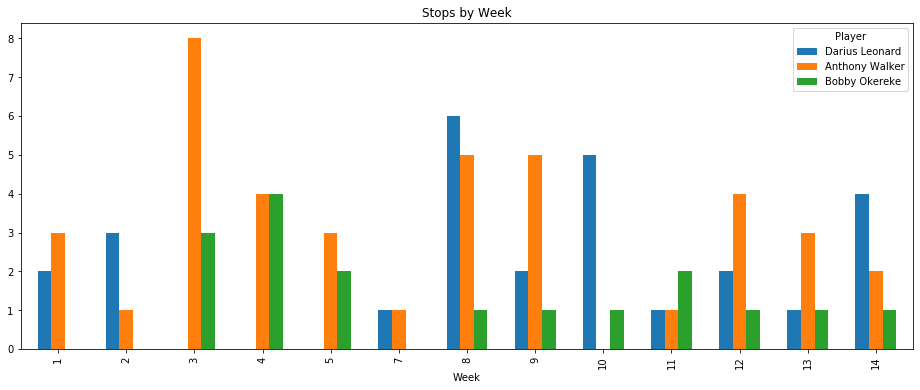

In [667]:
x=DL_df2['Week']

aa_lb=dict(zip(x,DL_df2['Stop']))
bb_lb=dict(zip(x,AW_df2['Stop']))
cc_lb=dict(zip(x,BO_df2['Stop']))



dfbar_lbs = pd.DataFrame({'Darius Leonard': aa_lb, 'Anthony Walker': bb_lb, 'Bobby Okereke': cc_lb}, index=x)

# Non-stacked bar plot
dfbar_lbs.plot.bar(figsize=(16, 6),width = 0.6)

plt.title("Stops by Week")
plt.legend(title="Player")
plt.show() 

### Cornerback Group

In [522]:
cbs_summed = summed_df.loc[['Kenny Moore','Pierre Desir','Rock Ya-Sin','Quincy Wilson','Marvell Tell']]
cbs_summed

,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,
Kenny Moore,651,7,3,3,53,7,31,0.0,2,1,0,110.0,39,371
Pierre Desir,409,0,0,0,25,5,5,0.0,1,3,4,95.4,29,92
Rock Ya-Sin,571,0,0,0,38,3,14,0.0,1,1,7,151.9,28,474
Quincy Wilson,105,0,0,0,8,0,2,0.0,0,0,3,74.2,10,167
Marvell Tell,219,0,0,0,17,0,5,1.0,0,5,2,72.0,17,14


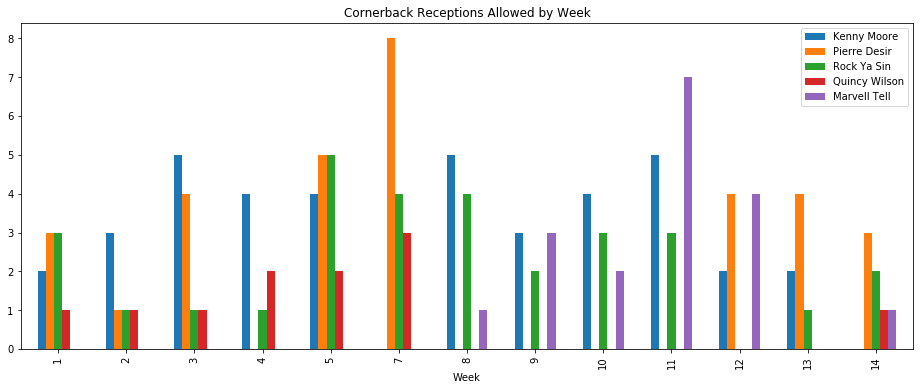

In [668]:
xcbs=KM_df2['Week']

aa_cb=dict(zip(xcbs,KM_df2['rec']))
bb_cb=dict(zip(xcbs,PD_df2['rec']))
cc_cb=dict(zip(xcbs,RYS_df2['rec']))
dd_cb=dict(zip(xcbs,QW_df2['rec']))
ee_cb=dict(zip(xcbs,MT_df2['rec']))

cbslabels = ['Kenny Moore','Pierre Desir','Rock Ya Sin','Quincy Wilson','Marvell Tell']


dfbar_cbs = pd.DataFrame({'Kenny Moore': aa_cb, 'Pierre Desir': bb_cb, 'Rock Ya Sin': cc_cb,'Quincy Wilson': dd_cb,'Marvell Tell': ee_cb}, index=x)

# Non-stacked bar plot
dfbar_cbs.plot.bar(figsize=(16, 6),width = 0.6)

plt.title("Cornerback Receptions Allowed by Week")
plt.legend(labels = cbslabels)
plt.show()


### Safety Group

In [525]:
safs = summed_df.loc[['Malik Hooker','Clayton Geathers','Khari Willis','George Odum']]
safs

,T_Snaps,T_pressure,Sacks,Hurries,T_Tackles,Missed_Tackles,Stop,Forced_Fumble,Int,Pass_Breakup,Penalty,y_per_rec,rec,red_count
Player,,,,,,,,,,,,,,
Malik Hooker,504,0,0,0,23,7,7,0.0,1,1,0,30.0,4,216
Clayton Geathers,418,0,0,0,29,5,8,0.0,1,0,1,44.8,8,82
Khari Willis,459,4,0,4,39,6,15,0.0,0,1,1,56.5,15,122
George Odum,224,2,1,0,18,3,4,1.0,0,0,1,80.5,7,45


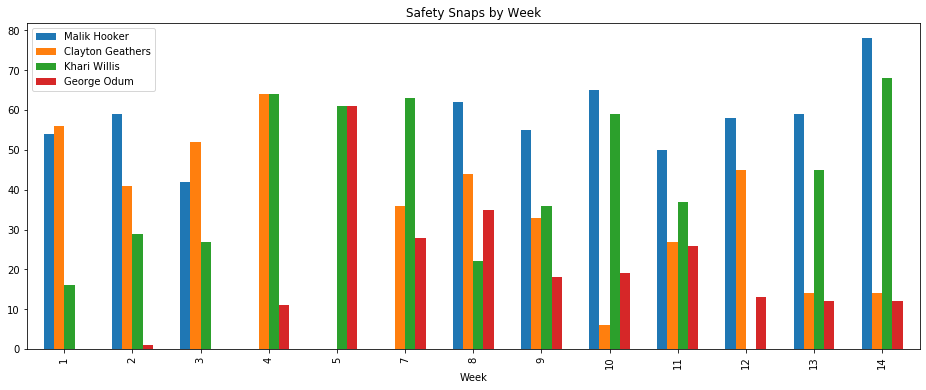

In [526]:
xsaf=KM_df2['Week']

aa_saf=dict(zip(xsaf,MH_df2['T_Snaps']))
bb_saf=dict(zip(xsaf,CG_df2['T_Snaps']))
cc_saf=dict(zip(xsaf,KW_df2['T_Snaps']))
dd_saf=dict(zip(xsaf,GO_df2['T_Snaps']))


saflabels = ['Malik Hooker','Clayton Geathers','Khari Willis','George Odum']


dfbar_saf = pd.DataFrame({'Malik Hooker': aa_saf, 'Clayton Geathers': bb_saf, 'Khari Willis': cc_saf,'George Odum': dd_saf}, index=x)

# Non-stacked bar plot
dfbar_saf.plot.bar(figsize=(16, 6),width = 0.6)

plt.title("Safety Snaps by Week")
plt.legend(labels = saflabels)
plt.show()

### Edge Group

In [664]:
edges = merged_df.loc[['Justin Houston','Jabaal Sheard','Ben Banogu','Al-Quadin Muhammad','Kemoko Turay']]
